# About the Project

## Case Study 1.1.2: Finding Themes in Project Descriptions

Instructor: Tamara Broderick
Activity Type: Optional 
Case Study Description: Using Latent Dirichlet Allocation to discover topics in a corpus of text. Finding Themes in Project Descriptions - LDA Analysis.
Self-Help Documentation: In this document, we walk through some tips to help you with doing your own analysis on MIT EECS faculty data using stochastic variational inference on LDA. We provide some examples for the following programming environment: Python.
Download Self-Help Documentation

Time Required: The time required to do this activity varies depending on your experience in the required programming background. We suggest planning somewhere between 1 & 3 hours. Remember, this is an optional activity for participants looking for hands-on experience.
Have questions? Feel free to discuss this case study with other participants in the Discussion Forum under Module 1 - Case Studies Section.



## Scraping Data from Web

In [1]:
#Importing Libraries
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
# Tokenize
#from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
%matplotlib inline

%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os
os.chdir('..')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [2]:
#Gathering data from the web as per request
#arxiv.org/find/(subject)/1/au:+(lastname)_(initial)/0/1/0/all/0/1

#foumd that url above is obsolete there is new one:
#https://arxiv.org/search/?query=Mohammad+Alizadeh&searchtype=all&abstracts=show&order=-announced_date_first&size=50
#note that by default it will bring 50 per peage/author

# we could scrape the name list of MIT EECS faculty members. 
# page with members: https://www.eecs.mit.edu/people/faculty-advisors/

try:
    pageMembers = requests.get('https://www.eecs.mit.edu/people/faculty-advisors/')
    soupMembers = BeautifulSoup(pageMembers.content, 'html.parser')
except ValueError:
    print ('something went wrong trying to get elements from the page', ValueError )

In [3]:
##scrapping from web the name of members and preparing a list
countPeople = 0
listPeople = []
listPeopleHtml = soupMembers.find_all("div", class_="views-field views-field-title")

for person in listPeopleHtml:
    name = person.span.a
    if name is None:
        name = person.span
    listPeople.append(name.text)
    countPeople += 1

#Creating Pandas with 3 columns - Name, First Name and Last Name
name_df = pd.DataFrame(listPeople, columns =['name'])

name_df[['first_name','last_name']] = name_df['name'].loc[name_df['name'].str.split().str.len() == 2].str.split(expand=True)

#Including the URL as part of the dataset
name_df['find_url'] = 'https://arxiv.org/search/?query=' + name_df['first_name'] + '+' + name_df['last_name'] + '&searchtype=all&abstracts=show&order=-announced_date_first&size=50'


In [4]:
#Getting Tamara example:
name_df.iloc[23]

name                                           Tamara Broderick
first_name                                               Tamara
last_name                                             Broderick
find_url      https://arxiv.org/search/?query=Tamara+Broderi...
Name: 23, dtype: object

In [5]:
urlAbstract = name_df.iloc[23][3]

try:
    pageAbstract = requests.get(urlAbstract)
    soupAbstract = BeautifulSoup(pageAbstract.content, 'html.parser')
except ValueError:
    print ('something went wrong trying to get elements from the page', ValueError )

In [6]:
#Getting the abstract
# abstract mathjax
countAbstract = 0
listAbstractTitle = []
listAbstract = []

#listAbstractHtml = soupAbstract.find_all(class_="abstract-short has-text-grey-dark mathjax")
listAbstractHtml = soupAbstract.find_all(class_="arxiv-result")

for item in listAbstractHtml:
    #name = person.span.a
    #if name is None:
    #    name = person.span
    #listPeople.append(name.text)
    
    #Getting title of the article
    title = item.find(class_="title is-5 mathjax").text.strip(' \n\t')
    listAbstractTitle.append(title)
    
    #Getting the article
    #some problemas as there is a short and long versio. We will try to capture the full version
    #of the abstract
    tokenMore = 'More\n\n\n        '
    tokenLess = '\n        △ Less\n\n'
    
    abstract = item.find(class_="abstract mathjax").text
    
    init = abstract.find(tokenMore)
    end = abstract.find(tokenLess)
    
    listAbstract.append(abstract[init + len(tokenMore):end])
    
    
    
    
    countAbstract += 1


#combining the two lists
listTitle_Abstract = {'titles':listAbstractTitle, 'abstract':listAbstract}

#creating pandas
abstractAndTitles_df = pd.DataFrame(listTitle_Abstract, columns=['titles', 'abstract'])

## Exploring Visual Data

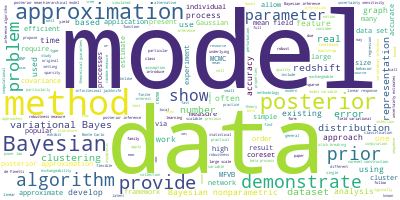

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(abstractAndTitles_df['titles'].values))
long_string += ','.join(list(abstractAndTitles_df['abstract'].values))
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Data Processing

/Users/claudiogimenestoledo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


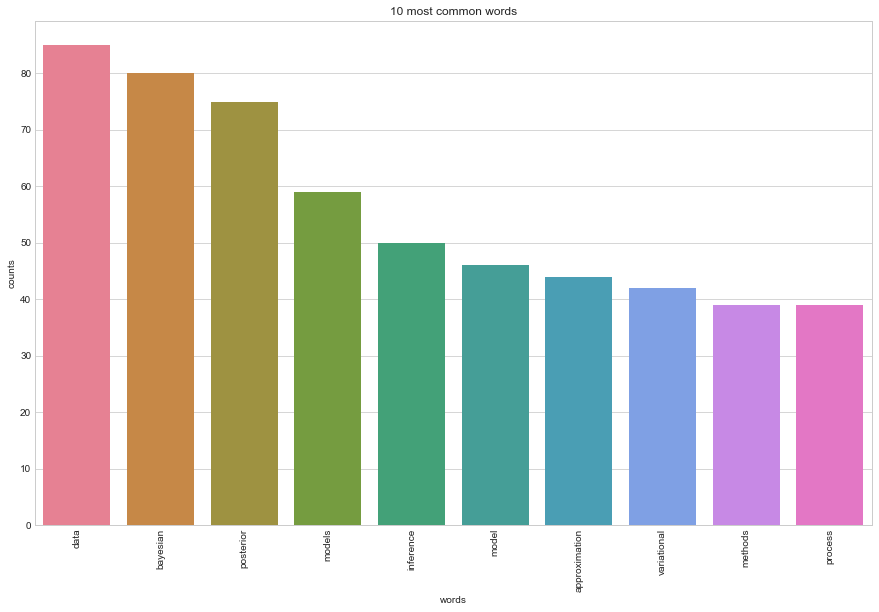

In [8]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(long_string.split())
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## LDA model training

In [9]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
bayesian posterior demonstrate fast based high variables set redshift beta

Topic #1:
model methods robustness analysis representations algorithm new accurate bounds efficient

Topic #2:
models variational mean algorithms accuracy work feature local quality field

Topic #3:
data bayes number method mfvb uncertainty approximate time use distribution

Topic #4:
inference approximation process prior large error clustering nonparametric real random


## Conclusion

In [37]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
pyLDAvis.enable_notebook()

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

sklearn_lda.pyLDAvis.display(LDAvis_prepared)

CPU times: user 201 ms, sys: 8.15 ms, total: 210 ms
Wall time: 427 ms
